🧠 Step 1: Import Required Libraries

In [1]:
# %pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from transformers import CLIPModel, CLIPProcessor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchvision import models

d:\Programming\Cancer_Detection_Model\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


🧩 Step 2: Define Transformations

Transformations help resize images and normalize them for training.

In [5]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
# VGG16 requires specific ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)
test_dataset=datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Testing", transform=transform)


# Class names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
print(train_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995

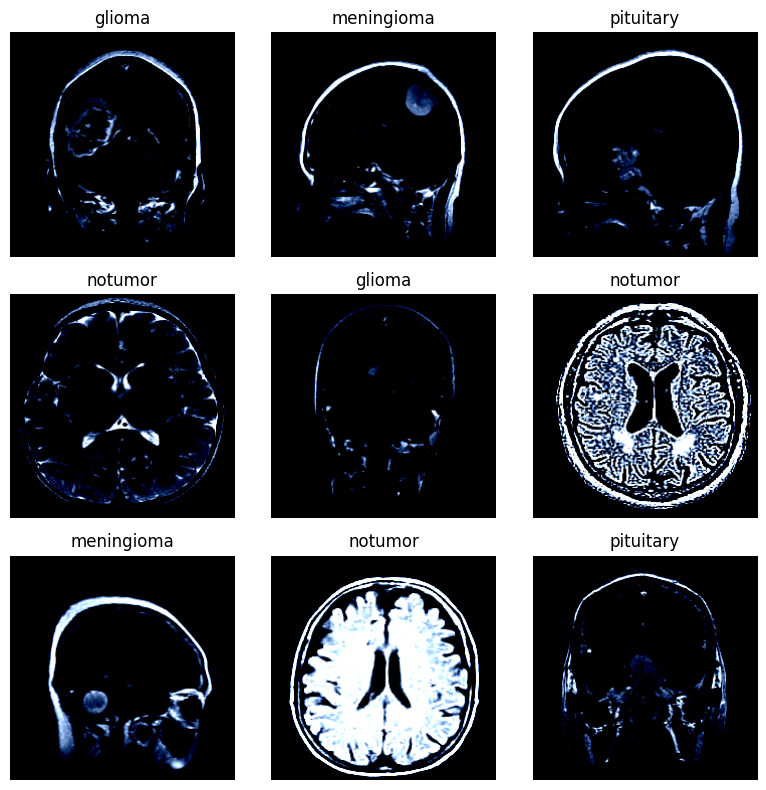

In [7]:
import random
import numpy as np

# Pick 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    
    # Tensor → Numpy for plotting
    img = img.permute(1, 2, 0).numpy()
    
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [8]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


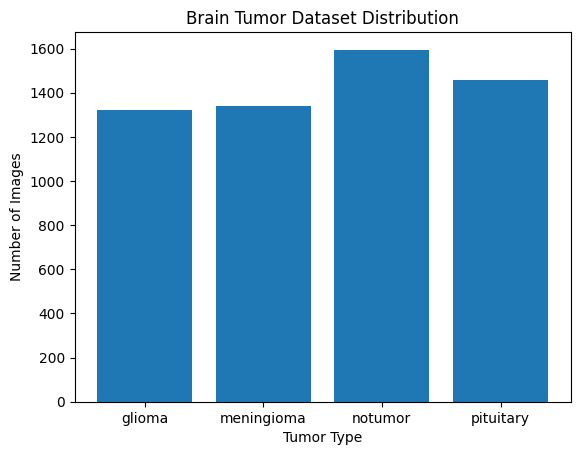

In [9]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


📦 Step 3: Make Datasets class

In [10]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

⚙️ Step 4: Create Dataloaders

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 # You can adjust this

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

print(f"Train loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

Train loader: 179 batches
Test loader: 41 batches


In [16]:
# Load pre-trained VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# 1. Freeze the feature-extracting layers (convolutional base)
for param in model.features.parameters():
    param.requires_grad = False

# 2. Replace the final classifier layer
# VGG16's classifier[6] is nn.Linear(4096, 1000)
# We replace it with a new layer for our 4 classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)

# Move the model to the GPU
model = model.to(device)

print("VGG16 model loaded and final layer replaced.")
# print(model.classifier) # Uncomment to see the new classifier structure

VGG16 model loaded and final layer replaced.


🧩 Step 5: Make Model Convolutional Neural Neteork

In [18]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # corrected size
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
NUM_CLASSES = len(classes)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 4


In [20]:
model = CNN(input_channels=3)
model.to(device)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

In [45]:
from torch import optim

# Define hyperparameters
epochs = 50
learning_rate = 0.001

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
# We only want to train the parameters of the classifier (the layer we just added)
optimizer = optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=0.9)

In [46]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [32]:
from tqdm import tqdm

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_train_loss = total_epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_features, val_labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            val_features = val_features.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_features)
            v_loss = criterion(val_outputs, val_labels)

            val_loss += v_loss.item()

            _, v_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (v_predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
          f"- Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.05it/s]


Epoch [1/50] - Train Loss: 0.5110, Train Acc: 81.57% - Val Loss: 0.5660, Val Acc: 77.04%


Epoch 2/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.16it/s]


Epoch [2/50] - Train Loss: 0.4569, Train Acc: 83.61% - Val Loss: 0.5447, Val Acc: 78.11%


Epoch 3/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.72it/s]


Epoch [3/50] - Train Loss: 0.4132, Train Acc: 84.89% - Val Loss: 0.4684, Val Acc: 81.01%


Epoch 4/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.06it/s]


Epoch [4/50] - Train Loss: 0.3781, Train Acc: 86.20% - Val Loss: 0.4464, Val Acc: 81.46%


Epoch 5/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.60it/s]


Epoch [5/50] - Train Loss: 0.3469, Train Acc: 87.36% - Val Loss: 0.4191, Val Acc: 83.07%


Epoch 6/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.50it/s]


Epoch [6/50] - Train Loss: 0.3208, Train Acc: 88.25% - Val Loss: 0.3897, Val Acc: 84.67%


Epoch 7/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.29it/s]


Epoch [7/50] - Train Loss: 0.2996, Train Acc: 89.13% - Val Loss: 0.4158, Val Acc: 82.99%


Epoch 8/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.24it/s]


Epoch [8/50] - Train Loss: 0.2805, Train Acc: 89.93% - Val Loss: 0.3410, Val Acc: 86.35%


Epoch 9/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]


Epoch [9/50] - Train Loss: 0.2528, Train Acc: 91.00% - Val Loss: 0.3346, Val Acc: 88.41%


Epoch 10/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.62it/s]


Epoch [10/50] - Train Loss: 0.2328, Train Acc: 92.31% - Val Loss: 0.3035, Val Acc: 88.18%


Epoch 11/50 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.34it/s]


Epoch [11/50] - Train Loss: 0.2143, Train Acc: 92.38% - Val Loss: 0.2833, Val Acc: 89.17%


Epoch 12/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.70it/s]


Epoch [12/50] - Train Loss: 0.1944, Train Acc: 93.80% - Val Loss: 0.2566, Val Acc: 90.62%


Epoch 13/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.95it/s]


Epoch [13/50] - Train Loss: 0.1814, Train Acc: 94.07% - Val Loss: 0.2765, Val Acc: 90.08%


Epoch 14/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]


Epoch [14/50] - Train Loss: 0.1665, Train Acc: 94.80% - Val Loss: 0.2363, Val Acc: 91.46%


Epoch 15/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.60it/s]


Epoch [15/50] - Train Loss: 0.1499, Train Acc: 95.33% - Val Loss: 0.2293, Val Acc: 90.85%


Epoch 16/50 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.95it/s]


Epoch [16/50] - Train Loss: 0.1340, Train Acc: 96.20% - Val Loss: 0.2249, Val Acc: 90.77%


Epoch 17/50 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]


Epoch [17/50] - Train Loss: 0.1224, Train Acc: 96.55% - Val Loss: 0.2018, Val Acc: 91.61%


Epoch 18/50 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]


Epoch [18/50] - Train Loss: 0.1103, Train Acc: 97.25% - Val Loss: 0.2049, Val Acc: 92.60%


Epoch 19/50 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.96it/s]


Epoch [19/50] - Train Loss: 0.1000, Train Acc: 97.43% - Val Loss: 0.1941, Val Acc: 92.22%


Epoch 20/50 [Val]: 100%|██████████| 41/41 [00:10<00:00,  3.97it/s]


Epoch [20/50] - Train Loss: 0.0910, Train Acc: 97.72% - Val Loss: 0.1652, Val Acc: 93.90%


Epoch 21/50 [Val]: 100%|██████████| 41/41 [00:10<00:00,  4.00it/s]


Epoch [21/50] - Train Loss: 0.0843, Train Acc: 97.90% - Val Loss: 0.1788, Val Acc: 93.97%


Epoch 22/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.98it/s]


Epoch [22/50] - Train Loss: 0.0729, Train Acc: 98.60% - Val Loss: 0.1543, Val Acc: 94.20%


Epoch 23/50 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.17it/s]


Epoch [23/50] - Train Loss: 0.0688, Train Acc: 98.69% - Val Loss: 0.1619, Val Acc: 95.04%


Epoch 24/50 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.36it/s]


Epoch [24/50] - Train Loss: 0.0614, Train Acc: 98.81% - Val Loss: 0.1533, Val Acc: 94.28%


Epoch 25/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.30it/s]


Epoch [25/50] - Train Loss: 0.0546, Train Acc: 98.95% - Val Loss: 0.1628, Val Acc: 94.89%


Epoch 26/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.61it/s]


Epoch [26/50] - Train Loss: 0.0494, Train Acc: 99.02% - Val Loss: 0.1312, Val Acc: 95.35%


Epoch 27/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.10it/s]


Epoch [27/50] - Train Loss: 0.0432, Train Acc: 99.37% - Val Loss: 0.1284, Val Acc: 95.50%


Epoch 28/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.71it/s]


Epoch [28/50] - Train Loss: 0.0403, Train Acc: 99.53% - Val Loss: 0.1443, Val Acc: 94.97%


Epoch 29/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]


Epoch [29/50] - Train Loss: 0.0360, Train Acc: 99.60% - Val Loss: 0.1244, Val Acc: 95.42%


Epoch 30/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.32it/s]


Epoch [30/50] - Train Loss: 0.0316, Train Acc: 99.65% - Val Loss: 0.1254, Val Acc: 95.65%


Epoch 31/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [31/50] - Train Loss: 0.0294, Train Acc: 99.67% - Val Loss: 0.1252, Val Acc: 95.50%


Epoch 32/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.07it/s]


Epoch [32/50] - Train Loss: 0.0261, Train Acc: 99.82% - Val Loss: 0.1230, Val Acc: 95.27%


Epoch 33/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.01it/s]


Epoch [33/50] - Train Loss: 0.0247, Train Acc: 99.81% - Val Loss: 0.1178, Val Acc: 95.88%


Epoch 34/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.24it/s]


Epoch [34/50] - Train Loss: 0.0211, Train Acc: 99.89% - Val Loss: 0.1167, Val Acc: 96.11%


Epoch 35/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.95it/s]


Epoch [35/50] - Train Loss: 0.0200, Train Acc: 99.88% - Val Loss: 0.1209, Val Acc: 95.96%


Epoch 36/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  5.01it/s]


Epoch [36/50] - Train Loss: 0.0187, Train Acc: 99.89% - Val Loss: 0.1213, Val Acc: 95.88%


Epoch 37/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.72it/s]


Epoch [37/50] - Train Loss: 0.0175, Train Acc: 99.91% - Val Loss: 0.1239, Val Acc: 95.65%


Epoch 38/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.16it/s]


Epoch [38/50] - Train Loss: 0.0155, Train Acc: 99.96% - Val Loss: 0.1163, Val Acc: 95.88%


Epoch 39/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [39/50] - Train Loss: 0.0144, Train Acc: 99.96% - Val Loss: 0.1168, Val Acc: 95.88%


Epoch 40/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]


Epoch [40/50] - Train Loss: 0.0138, Train Acc: 99.96% - Val Loss: 0.1149, Val Acc: 95.88%


Epoch 41/50 [Val]: 100%|██████████| 41/41 [00:05<00:00,  6.87it/s]


Epoch [41/50] - Train Loss: 0.0127, Train Acc: 99.95% - Val Loss: 0.1158, Val Acc: 96.03%


Epoch 42/50 [Val]: 100%|██████████| 41/41 [00:05<00:00,  6.92it/s]


Epoch [42/50] - Train Loss: 0.0110, Train Acc: 99.98% - Val Loss: 0.1151, Val Acc: 95.88%


Epoch 43/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]


Epoch [43/50] - Train Loss: 0.0109, Train Acc: 99.96% - Val Loss: 0.1152, Val Acc: 95.80%


Epoch 44/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]


Epoch [44/50] - Train Loss: 0.0097, Train Acc: 99.98% - Val Loss: 0.1149, Val Acc: 96.11%


Epoch 45/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.76it/s]


Epoch [45/50] - Train Loss: 0.0096, Train Acc: 99.98% - Val Loss: 0.1175, Val Acc: 96.11%


Epoch 46/50 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.35it/s]


Epoch [46/50] - Train Loss: 0.0098, Train Acc: 99.96% - Val Loss: 0.1190, Val Acc: 96.03%


Epoch 47/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.94it/s]


Epoch [47/50] - Train Loss: 0.0085, Train Acc: 99.98% - Val Loss: 0.1170, Val Acc: 95.96%


Epoch 48/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.21it/s]


Epoch [48/50] - Train Loss: 0.0084, Train Acc: 99.98% - Val Loss: 0.1160, Val Acc: 95.96%


Epoch 49/50 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]


Epoch [49/50] - Train Loss: 0.0075, Train Acc: 99.98% - Val Loss: 0.1134, Val Acc: 96.03%


Epoch 50/50 [Val]: 100%|██████████| 41/41 [00:08<00:00,  4.99it/s]

Epoch [50/50] - Train Loss: 0.0074, Train Acc: 99.98% - Val Loss: 0.1157, Val Acc: 95.73%


In [33]:
model.eval()  # turn off dropout, batchnorm, etc.


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

Visualize the code

Plot Accuracy Graph

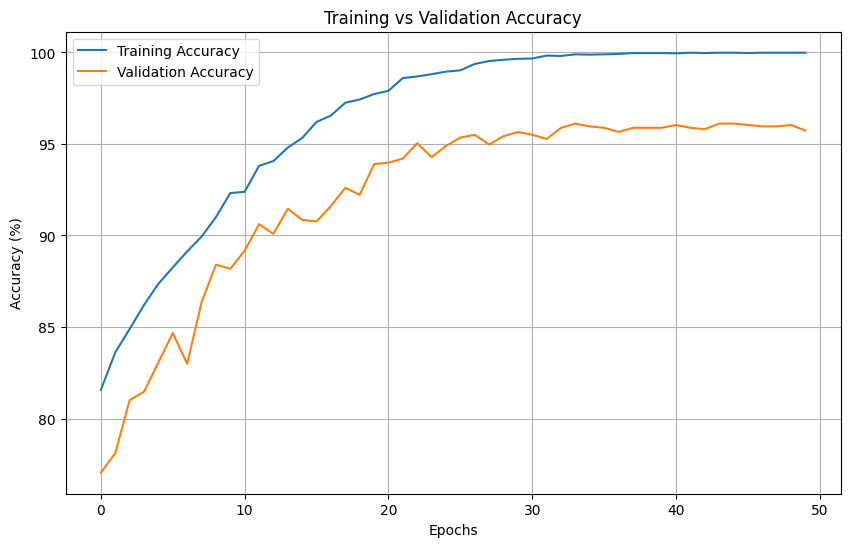

In [34]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plot Loss Graph

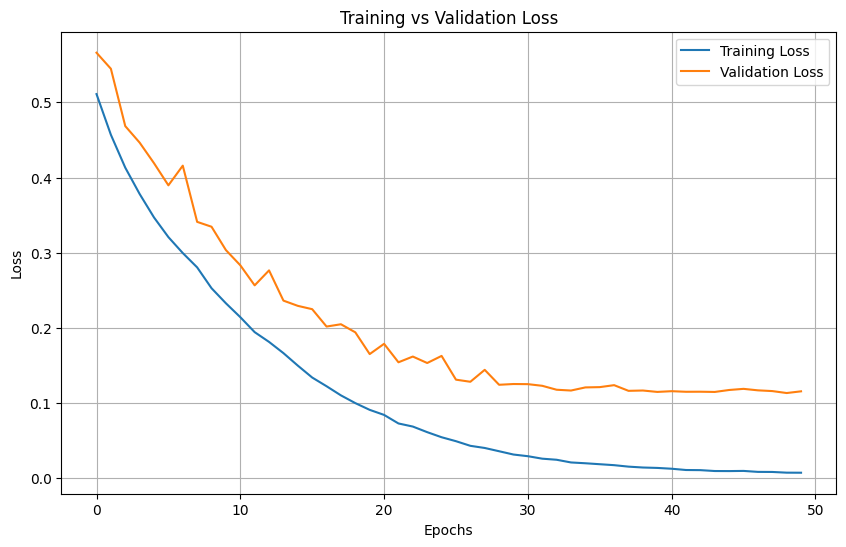

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Accuracy Test on test data

In [36]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 95.73%


Accuracy test on Test dataset

In [37]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 99.98%


In [38]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
cm = confusion_matrix(all_labels, all_preds)
cm


array([[269,  29,   0,   2],
       [ 13, 283,   7,   3],
       [  0,   0, 405,   0],
       [  0,   2,   0, 298]])

<Figure size 800x600 with 0 Axes>

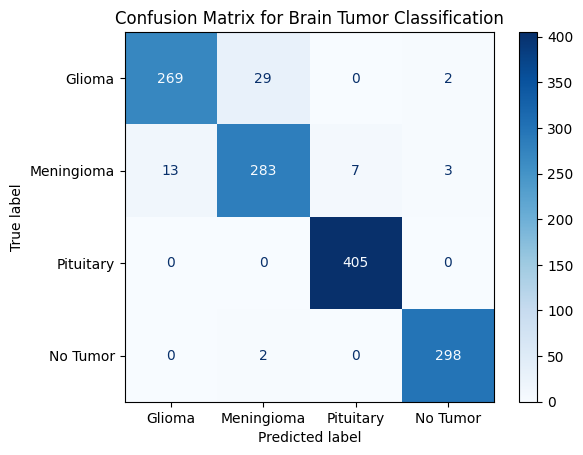

In [41]:
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Brain Tumor Classification")
plt.show()


save model

In [42]:
# # # Save
# # torch.save(model, "model.pth")

# # # Load
# model = torch.load("model.pth")
# model.eval()

In [43]:
from PIL import Image

# Define class names (in same order as your training labels)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load model
model = torch.load("model.pth", map_location=torch.device('cpu'))
model.eval()

# Prediction function
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    print(f"\n🧠 Predicted Tumor Type: {classes[predicted.item()]}")
    return classes[predicted.item()]

# Example usage
# predict("sample_mri.jpg")


C:\Users\sande\AppData\Local\Temp\ipykernel_15484\2845487532.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model.pth", map_location=torch.device('c

In [44]:
predict(r'D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Tr-gl_0011.jpg')
    


🧠 Predicted Tumor Type: notumor


'notumor'